In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
#from Learning.diffusion_utilities import *
from helper_function import *

In [2]:
file_path='sprites_1788_16x16.npy'
file_path_labels="sprite_labels_nc_1788_16x16.npy"

In [3]:
data=np.load(file_path)
print(data.shape)
labels=np.load(file_path_labels)
print(labels.shape)

(89400, 16, 16, 3)
(89400, 5)


1


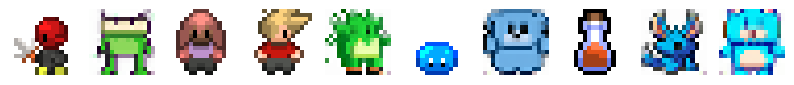

2


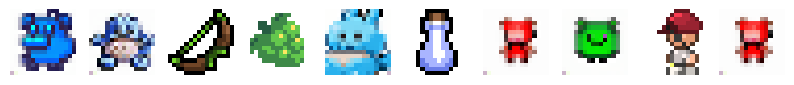

3


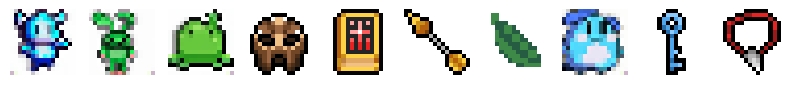

In [4]:
number_of_rows=3

for k in range(number_of_rows):
    print(k+1)
    fig,axes=plt.subplots(nrows=1,ncols=10,figsize=(10,10))
    for ax in axes.flat:
        i = np.random.randint(0,len(labels))
        ax.imshow(data[i],cmap='gray')
        ax.axis("off")
    plt.show()

In [5]:
j = 4
condition = labels[:,j]==1.0
indices = np.where(condition)[0]

2


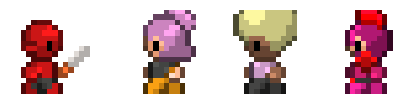

3


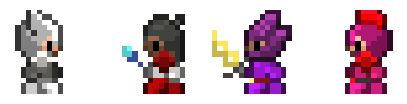

In [6]:
for k in range(1,3):
    print(k+1)
    fig,axes=plt.subplots(nrows=1, ncols=4, figsize=(5, 5))
    for ax in axes.flat:
        i = np.random.choice(indices)
        ax.imshow(data[i],cmap='gray')
        ax.axis("off")
    plt.show()

In [7]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels

In [8]:
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        
        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        
        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)
        
        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x

In [9]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        
        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]
        
        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

In [10]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        #embed input data into a lower-dimensional space
        self.input_dim = input_dim
        
        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        
        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

In [11]:
class ContextUnet(nn.Module):
    def __init__(self,in_channels, n_feat=256, n_cfeat=10, height=28) -> None:
        super(ContextUnet,self).__init__()

        self.in_channels=in_channels
        self.n_feat=n_feat # number of feature, usually control the widht and the depth of the U net 
        self.n_cfeat= n_cfeat # Contextual feature dimensions 
        self.h= height # must be divisible by 4 

        # initialize the initial convolutional layers 
        self.init_conv= ResidualConvBlock(in_channels,n_feat,is_res=True)

        #initialize the down-sampling path of the u net with two labels 
        self.down1=UnetDown(n_feat,n_feat)
        self.down2=UnetDown(n_feat, 2* n_feat)

        self.to_vec=nn.Sequential(nn.AvgPool2d((4)),nn.GELU())

        #Embed the timestep and context labels with a one-layer fully connected neural network 
        self.timeembed1=EmbedFC(1,2*n_feat)
        self.timeembed2=EmbedFC(1,1*n_feat)
        self.contextembed1=EmbedFC(n_cfeat,2*n_feat)
        self.contextembed2=EmbedFC(n_cfeat,1*n_feat)

        #initialize the up-sampling path of the u net with three levels 
        self.up0=nn.Sequential(
            nn.ConvTranspose2d(2*n_feat, 2* n_feat, self.h//4, self.h//4),
            nn.GroupNorm(8,2 * n_feat),
            nn.ReLU()
        )
        self.up1=UnetUp(4 * n_feat, n_feat)
        self.up2=UnetUp(2 * n_feat, n_feat)

        #initialize the final convolutional layers to map to the same number of the same number of channels as the input image 
        self.out=nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),#reduce number of feature maps 
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1)# map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch ,n_feat,h, w): input image 
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        
        x=self.init_conv(x)
        # pass the input image through the initial convolutional layers 
        down1=self.down1(x)
        down2=self.down2(down1)

        #convert the feature maps to a vector and apply an activation 
        hiddenvec=self.to_vec(down2)

        #mask out context if context mask == 1
        if c is None:
            c=torch.zeros(x.shape[0],self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out
    


In [12]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = './weights/'

# training hyperparameters
batch_size = 100
n_epoch =32
lrate=1e-3

In [13]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

In [14]:
# construct model

nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [15]:
# load dataset and construct optimizer
dataset = CustomDataset("./sprites_1788_16x16.npy", "./sprite_labels_nc_1788_16x16.npy", transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [16]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [17]:
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    pbar = tqdm(dataloader, mininterval=2 )
    for x, _ in pbar:   # x: images
        optim.zero_grad()
        x = x.to(device)
        
        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)
        
        # use network to recover noise
        pred_noise = nn_model(x_pert, t / timesteps)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step()

epoch 0


100%|██████████| 894/894 [02:12<00:00,  6.72it/s]


epoch 1


100%|██████████| 894/894 [01:47<00:00,  8.29it/s]


epoch 2


100%|██████████| 894/894 [00:44<00:00, 20.07it/s]


epoch 3


100%|██████████| 894/894 [00:44<00:00, 20.06it/s]


epoch 4


100%|██████████| 894/894 [00:44<00:00, 20.00it/s]


epoch 5


100%|██████████| 894/894 [00:45<00:00, 19.66it/s]


epoch 6


100%|██████████| 894/894 [00:45<00:00, 19.86it/s]


epoch 7


100%|██████████| 894/894 [00:44<00:00, 20.00it/s]


epoch 8


100%|██████████| 894/894 [00:44<00:00, 19.94it/s]


epoch 9


100%|██████████| 894/894 [00:44<00:00, 19.88it/s]


epoch 10


100%|██████████| 894/894 [00:46<00:00, 19.32it/s]


epoch 11


100%|██████████| 894/894 [00:45<00:00, 19.59it/s]


epoch 12


100%|██████████| 894/894 [00:45<00:00, 19.48it/s]


epoch 13


100%|██████████| 894/894 [00:47<00:00, 18.84it/s]


epoch 14


100%|██████████| 894/894 [00:46<00:00, 19.07it/s]


epoch 15


100%|██████████| 894/894 [00:44<00:00, 19.92it/s]


epoch 16


100%|██████████| 894/894 [00:44<00:00, 19.93it/s]


epoch 17


100%|██████████| 894/894 [00:44<00:00, 19.92it/s]


epoch 18


100%|██████████| 894/894 [00:44<00:00, 19.93it/s]


epoch 19


100%|██████████| 894/894 [00:44<00:00, 20.11it/s]


epoch 20


100%|██████████| 894/894 [00:44<00:00, 20.04it/s]


epoch 21


100%|██████████| 894/894 [00:44<00:00, 19.95it/s]


epoch 22


100%|██████████| 894/894 [00:44<00:00, 20.11it/s]


epoch 23


100%|██████████| 894/894 [00:42<00:00, 20.91it/s]


epoch 24


100%|██████████| 894/894 [00:43<00:00, 20.76it/s]


epoch 25


100%|██████████| 894/894 [00:42<00:00, 20.90it/s]


epoch 26


100%|██████████| 894/894 [00:42<00:00, 20.90it/s]


epoch 27


100%|██████████| 894/894 [00:42<00:00, 20.92it/s]


epoch 28


100%|██████████| 894/894 [00:42<00:00, 20.89it/s]


epoch 29


100%|██████████| 894/894 [00:42<00:00, 20.91it/s]


epoch 30


100%|██████████| 894/894 [00:42<00:00, 20.89it/s]


epoch 31


100%|██████████| 894/894 [00:43<00:00, 20.55it/s]


In [18]:
# save model periodically
os.path.exists(save_dir)
#os.mkdir(save_dir)
torch.save(nn_model.state_dict(), save_dir + f"model.pth")
print('saved model at ' + save_dir + f"model.pth")

saved model at ./weights/model.pth


In [19]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [20]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)    # predict noise e_(x_t,t)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [21]:
nn_model.load_state_dict(torch.load(f"{save_dir}/model.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


C:\Users\Anith\AppData\Local\Temp\ipykernel_35152\1092283974.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model.load_state_dict(torch.load(f"{save_dir}/model.pth",

In [22]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(32)
animation_ddpm = plot_sample(intermediate_ddpm,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [24]:
save_dir="/image"

In [25]:
#os.mkdir(save_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '/image'

In [26]:
samples, intermediate_ddpm = sample_ddpm(32)
animation_ddpm = plot_sample(intermediate_ddpm, 32, 4, save_dir, "ani_run", None, save=False)

# Save the animation as a GIF
animation_ddpm.save("ddpm_animation.gif", writer="imagemagick")

# Display the animation in the notebook
HTML(animation_ddpm.to_jshtml())

MovieWriter imagemagick unavailable; using Pillow instead.
